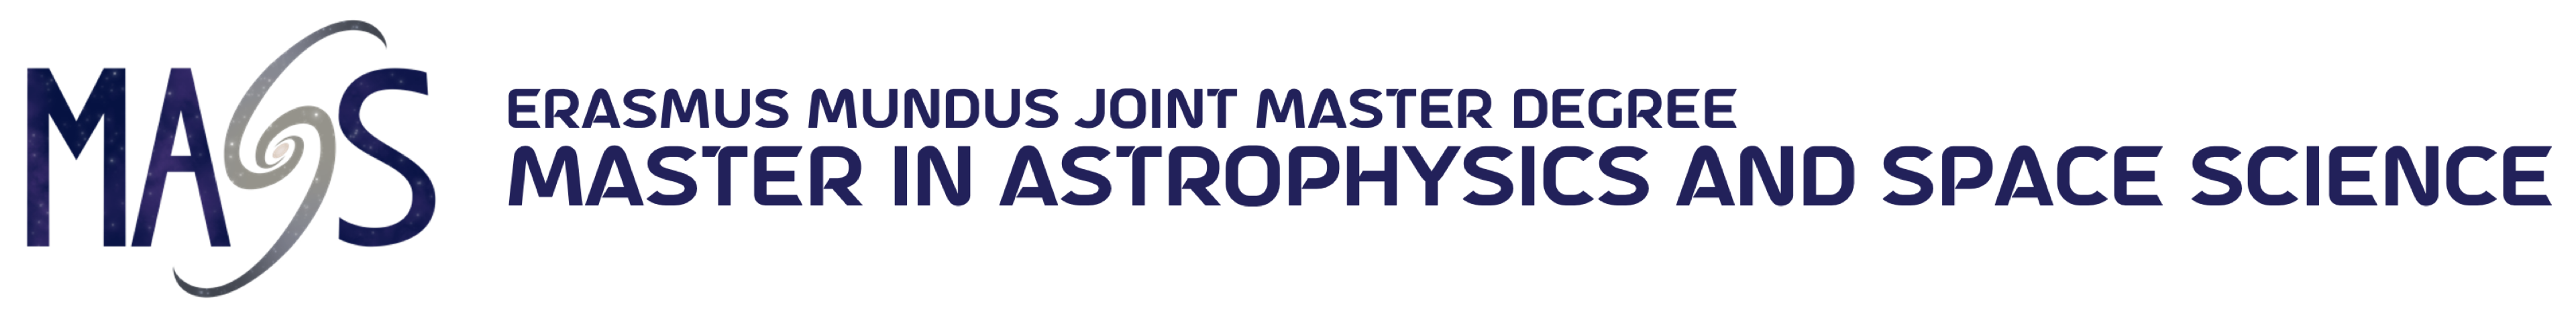

# Exposure Time Calculator

## HW #3: Astrophysical Data Reduction and Analysis Techniques

15 Nov 2024

Student: Francesca Borg

Instructor: Prof. Dragana Ilić

During observations of the selected target, the CCD camera records in addition to the object photons, other sources that generate an electrical signal in the system. All electrical signals not generated by photons from the source are characterized as noise. Specific sources of noise can be defined as follows:
- **Thermal noise (dark current):** caused by the thermal motion of electrons in the chip.
- **Read-out noise:** a result of the electronics during the readout process of the image.
- **Background noise:** referred to also as sky background caused by the light pollution.
- **Cosmic rays:** detection of cosmic rays that create false detections.
- **Pixel defects:** incorrect pixel readings (bad semiconductor junctions).

The quality of the image is defined by a parameter known as the **signal-to-noise ratio (SNR)**. Higher SNR values indicate better image quality. An unwritten rule is to use data with an SNR > 2 or 3. This raises the question: with the given setup (telescope + CCD), what is the required exposure time to achieve a given SNR value? The answer is not straightforward, and there is not absolute formula to precisely determine the exposure time. Instead, using certain assumptions, one can make an estimate.

**Signal noise**

In the simplest case, even if no other noise is assumed, some measurement error (signal noise) still exists. This noise originates from the counting of photons arriving from the source. Photon detection on the CCD chip is a random process that follows a Poisson distribution, which gives that the registered noise is proportional to the square root of the number of photons that reach the CCD chip during the observed period, i.e., exposure time. With a linear increase in exposure time, the SNR grows with the square root of the exposure time. The detected signal is described by the **number of electrons per second** $[S_{sig}]=e-/s$.

**Thermal noise**

It is well known that particles move at a given temperature, and electrons in the semiconductor of the CCD chip behaves similarly. Thermal noise or so-called dark current is usually reduced by lowering the CCD's temperature. The lower the temperature, the smaller the thermal noise. However, here we assume that the camera is at a certain temperature for which the thermal noise must be considered. At this temperature, there is a finite probability that an electron from the semiconductor will fall into a potential well. Thermal noise can be removed during the calibration of images. In general, for non-calibrated images, the thermal noise is a characteristic of the camera at a given temperature and is described by the number of electrons generated in 1 hour per pixel $[S_{dc}] = e-/h/pix$.

**Background noise**

Light poluution is the primary source of the limiting magnitude of the optical instrument being used, whether it is the human eye or a telescope. Additionally, the Moon is another dominant source of background noise, which is why observational cycles are planned during moonless nights or directed at parts of the sky more than $90\degree$ away from the Moon. Background noise is a measurable quantity, and for a given location (depending on the Moon's phase), it is given as the number of electrons per unit time that fall on one pixel $[S_{sky}] = e-/s/pix$. It is often expressed in magnitudes per square arcsecond $[B_{sky}] = mag/arcsec^2$.

**Read-out noise**

During the readout process, the electronics can introduce additional electrons. The number of generated electrons can be predicted and is known for each camera, and it does not depend on the exposure time. The value of read-out noise is given as the number of electrons generated per pixel during a single readout $[S_{ro}^2] = e-/pix$.

In addition to the listed sources of noise, the SNR value is also affecteed by the so-called binning of the CCD image, that involves combining the charge from multiple adjacent pixels on a CCD into a single pixel before the image is red out. Binning changes the image size and resolution but results in an increase in the SNR (i.e., when reading a binned image, we register a larger number of photons (electrons) for the same value of the read-out noise). Furthermore, the pixel size of the CCD chip $[u] = \mu m$ influences the image resolution. Naturally, the quantum efficiency of the CCD chip also plays a significant role as it represents the ratio of generated electrons to the number of photons that reach the CCD chip and is typically denoted as $q$.

Based on the above, we can derive an equation that gives the SNR for a specific observed object. All sources of noise affecting the observation propagae quadratically, leading to the following expression:
$$SNR = \dfrac{S_{sig} t}{\sqrt{S_{sig}t+R_{sky}t+S_{dc}tn+S_{ro}^2 n}}$$
where:
- $t$ is the exposure time (in seconds)
- $n$ is the number of pixel covering the source on the CCD image
- $R_{sky}$ is the number of electrons per unit time from the background detected on the CCD chip

Each noise source; signal noise $R_{sig}$, background noise $R_{sky}$, thermal noise $S_{dc}$, and read-out noise $S_{ro}$, contributed to the total noise, which is combined in quadrature.

In [28]:
#import necessary packages
import numpy as np
import scipy
import matplotlib.pyplot as plt

**Task 1**

Write a program in Python that, based on the input characteristics of the telescope (mirror diameter $D$ and $f$-number $f\#$), properties of the CCD chip ($q, S_{dc}, S_{ro}^2, u$), the observed object (magnitude $V$, seeing/PSF $r$), and the characteristics of the sky at the observatory site $S_{sky}$, calculates the exposure time needed to achieve a given SNR.

**Assume** the source's shape corresponds to a circular aperture of a given radius $r$ (in arcseconds), that the observation is conducted in the $V$-filter with a bandwidth of $900Å$. (**Assume** that the flux is constant within this interval. This assumption is valid because we are estimating the order of magnitude for the exposure time, not its exact value. Otherwise, things become more complicated.) **Assume** the object is at the zenith ($X=1$), and the flux for a zero-magnitude source is $f_0=1000 e-/s/cm^2/Å$).

In [29]:
#Write a program finding t from D, F_num, S_ro_sq, u, q, S_dc, r, SNR, V, S_sky

def get_exposure_time(D, f_num, S_ro_sq, u, q, S_dc, r, SNR, V, S_sky):
    '''
    Inputs
    
    FROM THE TELESCOPE:
    D = diameter of telescope mirror [meters]
    f_num = f-number of telescope [ratio]
    
    FROM THE CCD:
    S_ro_sq = square of CCD readout noise [electrons per pixel]
    u = CCD pixel size [in micrometer]
    q = CCD quantum efficiency [ratio]
    S_dc = CCD dark current [electrons per second per pixel]
    
    FROM THE OBJECT:
    r = object seeing (radius)
    SNR = signal-to-noise ratio
    V = object magnitude [^m]
    
    FROM THE OBSERVATORY CONDITIONS:
    S_sky = background sky noise [electrons per second per pixel]

    Output
    t = exposure time [seconds]
    '''

    #constants
    f0 = 1000 # [e-/s/cm^2/Angstrom]
    delta_lambda = 900 # [Angstrom]
    x = 1 # zenith position
    lambd = 5500 # [Angstrom]

    # INPUTTED VALUES
    #SNR = SNR #inputted
    #S_dc = S_dc #inputted
    #n = n #inputted
    R_sky = S_sky #inputted

    # DERIVED VALUES    
    S_ro = np.sqrt(S_ro_sq)

    #DERIVE S_sig
    A_cm2 = np.pi * ( (D * 100) / 2 )**2 # collecting area in cm²
    f_source = f0 * 10 ** (-0.4 * V) * delta_lambda  # Source flux [e-/s/cm²]
    S_sig = f_source * A_cm2 * q  # Signal in e-/s

    #DERIVE n
    focal_length = f_num * D # [m]
    pixel_scale = u / (focal_length * 1000) # [arcsec/pixel]
    n = np.pi * (r / pixel_scale)**2
    
    t = ( SNR**2 * (S_sig + R_sky + S_dc*n) + np.sqrt(SNR**4 * (S_sig + R_sky + S_dc * n)**2 + 4 * S_sig**2 * SNR**2 * S_ro**2 * n ) )/ (2 * S_sig**2)
    return t #exposure time

The above program calculates the exposure time $t$ for the input characteristics of the telescope ($D, f/\#$), properties of the CCD chip ($q, S_{dc}, S_{ro}^2, u$), observed object ($V, r$), characteristics of the sky at the observatory site ($S_{sky}$), and required SNR.

$$SNR = \dfrac{S_{sig} t}{\sqrt{S_{sig}t+R_{sky}t+S_{dc}tn+S_{ro}^2 n}}$$

By squaring both sides:

$$SNR^2 = \dfrac{(S_{sig} t)^2}{S_{sig}t+R_{sky}t+S_{dc}tn+S_{ro}^2 n}$$

and multipling throughout by the denominator $(S_{sig}t+R_{sky}t+S_{dc}tn+S_{ro}^2 n)$:

$$SNR^2(S_{sig}+R_{sky}+S_{dc}n)t+SNR^2 S_{ro}^2 n = S_{sig}^2 t^2$$

this relation can be rewritten as a quadrtic equation in $t$:

$$ S_{sig}^2 t^2 - SNR^2(S_{sig}+R_{sky}+S_{dc}n)t - SNR^2 S_{ro}^2 n = 0$$

Solving for $t$ gives us an equation for the exposure time in terms of the other characteristics of the telescope, CCD chip, sky conditions and observed object.

$$t = \dfrac{{SNR}^2(S_{sig}+R_{sky}+S_{dc}n) \pm \sqrt{{SNR}^4(S_{sig}+R_{sky}+S_{dc}n)^2 + 4 S_{sig}^2 {SNR}^2 S_{ro}^2 n} }{2 S_{sig}^2}$$

and taking only positive solutions, we have that:

$$t = \dfrac{{SNR}^2(S_{sig}+R_{sky}+S_{dc}n) + \sqrt{{SNR}^4(S_{sig}+R_{sky}+S_{dc}n)^2 + 4 S_{sig}^2 {SNR}^2 S_{ro}^2 n} }{2 S_{sig}^2}$$

We can calculate the detected signal $S_{sig}$, in number of electrons per second, as follows.

Using the assumption that the aperture is circular, the collecting area of the telescope can be computed from the diameter of the aperture, which is given in meters:

$$A_{m^2} = \pi \left(\dfrac{D~[m]}{2}\right)^2$$

In $cm^2$, this becomes:

$$A_{cm^2} = \pi \left(\dfrac{D \times 100 [cm]}{2}\right)^2$$

Now, in order to calculate the flux of the source, we use the given values for the zero-magnitude source flux $f_0=1000 e-/s/cm^2/Å$, and bandwidth of the $V$-filter of $\Delta \lambda = 900Å$, which are connected by the relation (following [10]):

$$f = f_0 \times \Delta \lambda \times 10^{-0.4 V}$$

where $V$ is the magnitude of the object in the $V$-band.

The number of electrons per second collected by the telescope is then given by combining the flux of the souce, collecting area of the telescope, and quantum efficiency of the CCD.

$$S_{sig} = f\times A_{telescope(cm^2)} \times q$$

In order to calculate the number of pixels covering the source on the CCD image $n$, we need to perform the following calculations.

The angular seeing / PSF is used to calculate the pixel coverage of the source using the CCD pixel scale $u [\mu m]$:

$$Pixel~scale = \dfrac{ u [\mu m] }{f\times 10^3} [arcsec/pixel]$$

where $f$ is the focal length of the telescope, computed as:

$$f = f/\# \times D$$

and the number of pixels covering the source on the CCD image can then be calculated as:

$$n = \pi \left(\dfrac{r}{pixel~scale}\right)^2$$

**Task 1 (cont.)**

Provide plots showing the dependance of the exposure time from:

1. $SNR=\overline{3,1003}$ for $r={0.01, 0.1, 0.5, 1, 3}$ arc sec

Unless otherwise stated, assume the following default parameters:

- telescope mirror diameter $D=8m$
- telescope f-number $f/\#=2.77$
- CCD read-out noise $S_{ro}^2=5 e-/pix$
- CCD pixel size $u=27\mu m$
- CCD quantum efficiency $q=0.7$
- CCD dark current $S_{dc}=3 e-/s/pix$
- object seeing $r=2 arcsec$
- signal-to-noise ratio $SNR=10$
- object magnitude $V=25^m$
- background sky noise $B_{sky}=22 mag/arcsec^2$

We use calculations similar to those above in order to conver the background sky noise from magnitudes per arcsec$^2$ to electrons per second per pixel.

In [30]:
#define method to convert B_sky to S_sky
def B_sky_to_S_Sky(B_sky, D, u, q, f_num):
    '''
    Input
    B_sky = background sky noise [magnitudes per arcsecond^2]
    
    D = Telescope mirror diameter [m].
    u = Pixel size of CCD [μm]
    q = Quantum efficiency of CCD [ratio].
    f_num = Telescope f-number
    
    Output
    S_sky = background sky noise [electrons per second per pixel]
    '''
    
    #constants
    f0 = 1000 # [e-/s/cm^2/Angstrom]
    delta_lambda = 900 # bandwidth [Angstrom]
    
    A_cm2 = np.pi * ( (D * 100) / 2 )**2 # collecting area in cm²
    
    focal_length = f_num * D # [m]
    pixel_scale = u / (focal_length * 1000) # [arcsec/pixel]
    pixel_area = pixel_scale**2 # area of a pixel [arcsec^2]
    
    f_sky = f0 * 10 ** (-0.4 * B_sky) * delta_lambda  # sky flux [e-/s/cm²]

    S_sky = f_sky * A_cm2 * q * pixel_area
    
    return S_sky

In [31]:
#define constants

D = 8 #[m]
f_num = 2.77
S_ro_sq = 5 #electrons per pixel
u = 27 #microns
q = 0.7
S_dc = 3 #electrons per second per pixel
r = 2 #arcsec
SNR = 10
V = 25 #^m
B_sky = 22 #mag/arcsec^2

# convert B_sky to S_sky
S_sky = B_sky_to_S_Sky(B_sky, D, u, q, f_num)

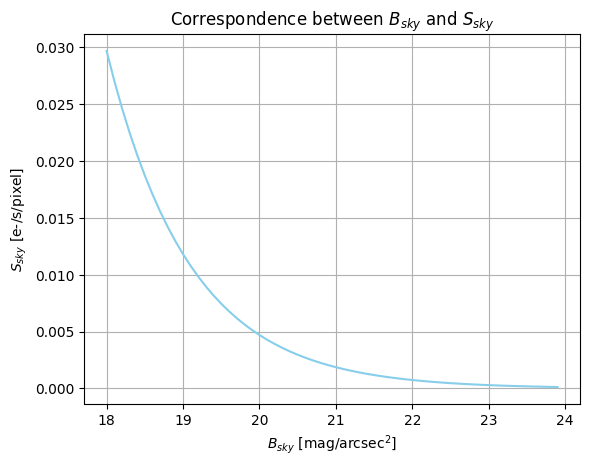

In [32]:
#test the above method:
B_sky_vals = np.arange(18, 24, 0.1)
plt.plot(B_sky_vals, B_sky_to_S_Sky(B_sky_vals, D, u, q, f_num), color='skyblue')

plt.xlabel(r"$B_{sky}$ [mag/arcsec$^2$]")
plt.ylabel(r"$S_{sky}$ [e-/s/pixel]")
plt.title("Correspondence between $B_{sky}$ and $S_{sky}$")
plt.grid()
plt.show()

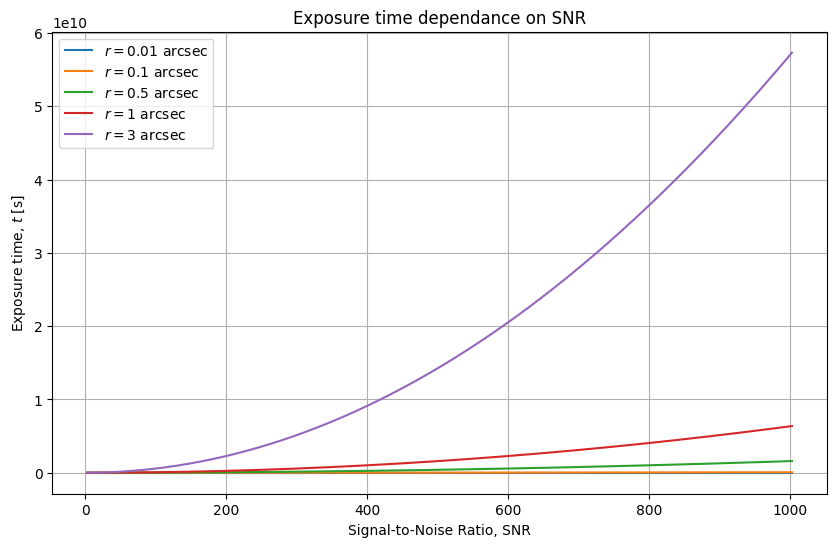

In [33]:
#define a singular plot area
plt.figure(figsize=(10, 6))
for this_r in [0.01, 0.1, 0.5, 1, 3]:

    snr_vals = np.arange(3, 1004, 1)
    t_snr_vals = []
    for this_snr in snr_vals:
        t = get_exposure_time(D, f_num, S_ro_sq, u, q, S_dc, this_r, this_snr, V, S_sky)
        t_snr_vals.append(t)
    
    # Plot graph
    plt.plot(snr_vals, t_snr_vals, label = r'$r=$'+str(this_r)+' arcsec')

#format plot
plt.xlabel("Signal-to-Noise Ratio, SNR")
plt.ylabel(r"Exposure time, $t$ [s]")
plt.title("Exposure time dependance on SNR")
plt.legend()
plt.grid()
plt.show()

**Task 1 (cont.)**

Provide plots showing the dependance of the exposure time from:

2. $V=\overline{10,30}$ for $D={1, 2.5, 6, 11}$ m

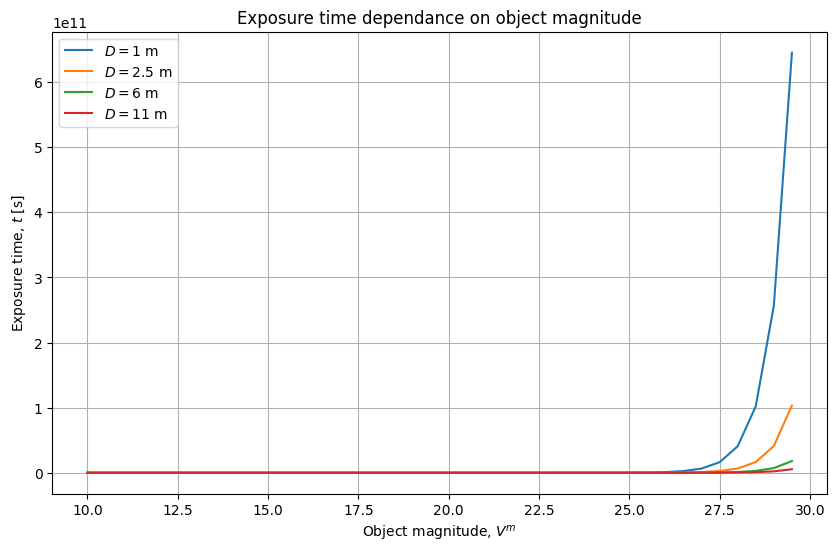

In [34]:
#define a singular plot area
plt.figure(figsize=(10, 6))

for this_D in [1, 2.5, 6, 11]:

    v_vals = np.arange(10, 30, 0.5)
    t_v_vals = []
    for this_v in v_vals:
        t = get_exposure_time(this_D, f_num, S_ro_sq, u, q, S_dc, r, SNR, this_v, S_sky)
        t_v_vals.append(t)
    
    # Plot graph
    plt.plot(v_vals, t_v_vals, label = r'$D=$'+str(this_D)+' m')

#format plot
plt.xlabel(r"Object magnitude, $V^m$")
plt.ylabel(r"Exposure time, $t$ [s]")
plt.title("Exposure time dependance on object magnitude")
plt.legend()
plt.grid()
plt.show()

**Task 1 (cont.)**

Provide plots showing the dependance of the exposure time from:

3. $B_{sky}=\overline{18,24} mag/arcsec^2$ for $r={0.01, 0.1, 0.5, 1, 3}$ arc sec

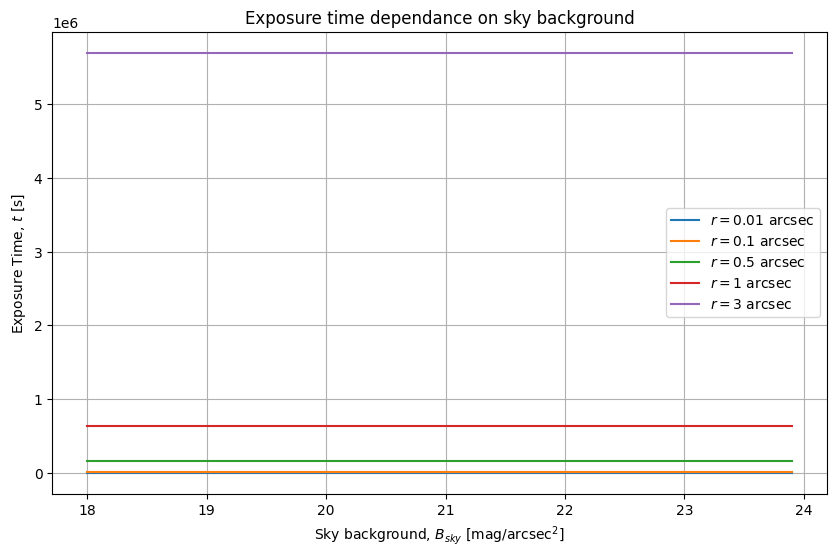

In [35]:
#define a singular plot area
plt.figure(figsize=(10, 6))

for this_r in [0.01, 0.1, 0.5, 1, 3]:

    B_sky_vals = np.arange(18, 24, 0.1)
    t_B_sky_vals = []
    
    for this_B_sky in B_sky_vals:
        #print(this_B_sky)
        this_S_sky = B_sky_to_S_Sky(this_B_sky, D, u, q, f_num)
        t = get_exposure_time(D, f_num, S_ro_sq, u, q, S_dc, this_r, SNR, V, this_S_sky)
        t_B_sky_vals.append(t)
    # Plot graph
    plt.plot(B_sky_vals, t_B_sky_vals, label = r'$r=$'+str(this_r)+' arcsec')

#format plot
plt.xlabel(r"Sky background, $B_{sky}$ [mag/arcsec$^2$]")
plt.ylabel("Exposure Time, $t$ [s]")
plt.title("Exposure time dependance on sky background")
plt.legend()
plt.grid()
plt.show()

In [36]:
t_B_sky_vals

[np.float64(5697773.4735862315),
 np.float64(5697773.473325972),
 np.float64(5697773.473088613),
 np.float64(5697773.472872138),
 np.float64(5697773.472674712),
 np.float64(5697773.472494656),
 np.float64(5697773.472330444),
 np.float64(5697773.4721806785),
 np.float64(5697773.472044093),
 np.float64(5697773.471919525),
 np.float64(5697773.471805917),
 np.float64(5697773.471702306),
 np.float64(5697773.471607812),
 np.float64(5697773.471521632),
 np.float64(5697773.471443034),
 np.float64(5697773.471371354),
 np.float64(5697773.471305979),
 np.float64(5697773.471246358),
 np.float64(5697773.471191982),
 np.float64(5697773.471142389),
 np.float64(5697773.471097162),
 np.float64(5697773.471055913),
 np.float64(5697773.471018295),
 np.float64(5697773.470983986),
 np.float64(5697773.470952696),
 np.float64(5697773.470924159),
 np.float64(5697773.470898133),
 np.float64(5697773.470874396),
 np.float64(5697773.470852749),
 np.float64(5697773.470833007),
 np.float64(5697773.470815001),
 np.fl

As can be observed from the printed values, variations in $B_{sky}$ have minimal effects on the total noise term, and thus do not significantly effect the required exposure time.

**Task 1 (cont.)**

Provide plots showing the dependance of the exposure time from:

4. $q=\overline{0.35, 0.99}$ for $u={5, 14, 27, 50} \mu m$

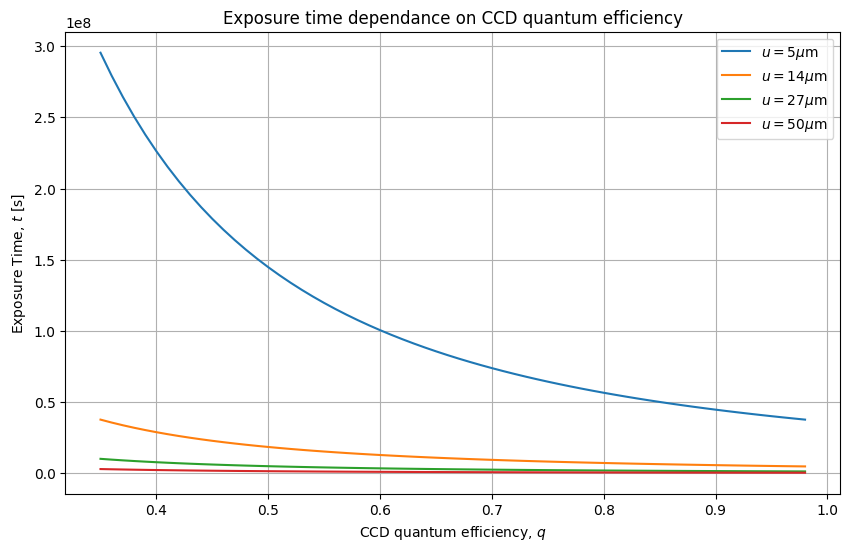

In [37]:
#define a singular plot area
plt.figure(figsize=(10, 6))

for this_u in [5, 14, 27, 50]:

    q_vals = np.arange(0.35, 0.99, 0.01)
    t_q_vals = []
    for this_q in q_vals:
        t = get_exposure_time(D, f_num, S_ro_sq, this_u, this_q, S_dc, r, SNR, V, S_sky)
        t_q_vals.append(t)
    
    # Plot graph
    plt.plot(q_vals, t_q_vals, label = r'$u=$'+str(this_u)+r'$\mu$m')

#format plot
plt.xlabel(r"CCD quantum efficiency, $q$")
plt.ylabel("Exposure Time, $t$ [s]")
plt.title("Exposure time dependance on CCD quantum efficiency")
plt.legend()
plt.grid()
plt.show()

**Task 1 (cont.)**

The above task is for a **point source**. However, the exposure time can be also estimated for an extended source (e.g., a galaxy). Assume the source brightness is $B_{sig} = 25 mag/arcsec^2$ and that it covers 4 x 4 pixels on the CCD chip. Provide plots showing changes in exposure time for $SNR = [3, 1003]$ and $n = {4, 15, 70}$.

To extend the above task to calculate the exposure time $t$ for an extended source, we first need to find the surface brightness for a two-dimensional source to obtain $S_{sig}$ in $e-/s/arcsec^2$.

In [38]:
#define method to convert B_sky to S_sky
def B_sig_to_S_sig(B_sig, D, q):
    '''
    Input
    B_sig = brightness of the source [mag/arcsecond^2]
    D = Telescope mirror diameter [m].
    q = Quantum efficiency of CCD [ratio].
    
    Output
    S_sig = signal from source [e-/s/arcsec^2]
    '''
    
    #constants
    f0 = 1000 # [e-/s/cm^2/Å]
    delta_lambda = 900 # bandwidth [Å]
    
    A_telescope_cm2 = np.pi * ( (D * 100) / 2 )**2 # collecting area of telescope in cm²
    
    f_sig = f0 * 10 ** (-0.4 * B_sig) * delta_lambda  # source flux [e-/s/cm²/Å]

    S_sig = f_sig * A_telescope_cm2 * q
    
    return S_sig

We also have to modify the program `get_exposure_time` to take into consideration the scaling necessary to compute the exposure time for a source spanning multiple pixels.

In [39]:
#Write a program finding t from D, F_num, S_ro_sq, u, q, S_dc, r, SNR, V, S_sky, AND n

def get_exposure_time_extended(D, f_num, S_ro_sq, u, q, S_dc, r, SNR, S_sky, n, S_sig):
    '''
    Inputs
    
    FROM THE TELESCOPE:
    D = diameter of telescope mirror [meters]
    f_num = f-number of telescope [ratio]
    
    FROM THE CCD:
    S_ro_sq = square of CCD readout noise [electrons per pixel]
    u = CCD pixel size [in micrometer]
    q = CCD quantum efficiency [ratio]
    S_dc = CCD dark current [electrons per second per pixel]
    
    FROM THE OBJECT:
    r = object seeing (radius)
    SNR = signal-to-noise ratio
    n = number of pixels spanning source in one dimension [pixels]
    S_sig = brightness of the source [e-/second/pixel]
    
    FROM THE OBSERVATORY CONDITIONS:
    S_sky = background sky noise [electrons per second per pixel]

    Output
    t = exposure time [seconds]
    '''

    #constants
    f0 = 1000 # [e-/s/cm^2/Angstrom]
    delta_lambda = 900 # [Angstrom]
    x = 1 # zenith position
    lambd = 5500 # [Angstrom]

    # INPUTTED VALUES
    #SNR = SNR #inputted
    #S_dc = S_dc #inputted
    #n = n #inputted
    total_n_pixels = n**2 # total amount of pixels which the source covers [pixels^2]
    #S_sig = S_sig #inputted

    # DERIVED VALUES    
    S_ro = np.sqrt(S_ro_sq)

    #DERIVE n
    focal_length = f_num * D # [m]
    pixel_scale = u / (focal_length * 1000) # [arcsec/pixel]
    pixel_area = pixel_scale**2 # area of a pixel [arcsec2]
    source_area = total_n_pixels * pixel_area # area of source [arcsec^2]

    #DERIVE S_sig_total
    S_sig_total = S_sig * source_area # signal rate of entire source [e-/s]

    #DERIVE R_sky
    R_sky = S_sky * total_n_pixels # sky background [e-]
    
    t = ( SNR**2 * (S_sig_total + R_sky + S_dc * total_n_pixels) + np.sqrt(SNR**4 * (S_sig_total + R_sky + S_dc * total_n_pixels)**2 + 4 * S_sig_total**2 * SNR**2 * S_ro**2 * total_n_pixels ) )/ (2 * S_sig_total**2)
    return t #exposure time

In [40]:
B_sig = 25 # source brightness [mag/arcsec^2]
S_sig = B_sig_to_S_sig(B_sig, D, q) # source signal [mag/arcsec^2]

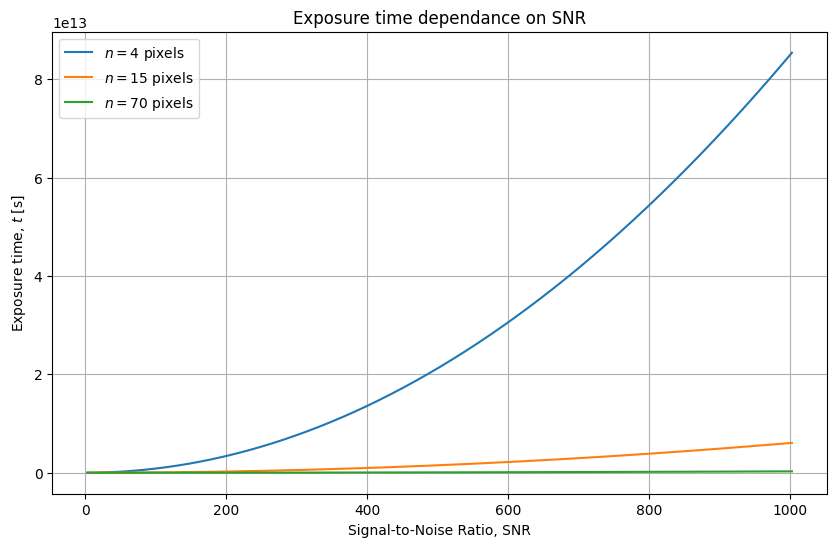

In [41]:
#define a singular plot area
plt.figure(figsize=(10, 6))
for this_n in [4, 15, 70]:

    snr_vals = np.arange(3, 1004, 1)
    t_snr_vals = []
    for this_snr in snr_vals:
        t = get_exposure_time_extended(D, f_num, S_ro_sq, u, q, S_dc, r, this_snr, S_sky, this_n, S_sig)
        t_snr_vals.append(t)
    
    # Plot graph
    plt.plot(snr_vals, t_snr_vals, label = r'$n=$'+str(this_n)+' pixels')

#format plot
plt.xlabel("Signal-to-Noise Ratio, SNR")
plt.ylabel(r"Exposure time, $t$ [s]")
plt.title("Exposure time dependance on SNR")
plt.legend()
plt.grid()
plt.show()

Noticeably, a longer exposure time is required to achieve the same SNR for a smaller source spanning a smaller number of pixels $n$.

**Task 2**

Calculate the exposure time for the Andromeda Galaxy (M31) to be observed with the Milanković telescope equipped with an SBIG STXL-6303E CCD camera (https://vidojevica.aob.rs/index.php?option=com_content&view=article&id=21&Itemid=28). Assume the sky brightness is $B_{sky}=19 mag/arcsec^2$. The required SNR is 100.

Approximating M31 as a point source, and obtaining the apparent magnitude from [13] and details about the Milanković telescope and SBIG STXL-6303E CCD camera from [14]:
- apparent magnitude of M31 $V=3.44^m$
- Milanković telescope seeing $r=0.7 arcsec$
- Milanković telescope mirror diameter $D= 1.4 m$
- Milanković telescope f-number $f/\#=8$
- SBIG STXL-6303E CCD read-out noise $S_{ro} = 15 e-/pix$
- SBIG STXL-6303E CCD pixel size $u= 9 \mu m$
- SBIG STXL-6303E CCD quantum efficiency $q=0.68$ (**assuming** it is operating at peak performance)
- SBIG STXL-6303E CCD dark current $S_{dc}= 0.5 e-/s/pix$

In [42]:
#define all the constants for the specific source and telescope
D_Mil = 1.4 # [m]
f_num_Mil = 8 # [ratio]
S_ro_Mil = 15 # [15 e-/pix]
S_ro_sq_Mil = S_ro_Mil**2 
u_Mil = 9 # [micrometers]
q_Mil = 0.68 # [ratio]
S_dc_Mil = 0.5 # [e-/s/pix]
r_Mil = 0.7 # [arcsec]
V_M31 = 3.44 #^m
SNR = 100
B_sky_Mil = 19
S_sky_Mil = B_sky_to_S_Sky(B_sky_Mil, D_Mil, u_Mil, q_Mil, f_num_Mil)

In [43]:
#compute and print exposure time
t_M31 = get_exposure_time(D_Mil, f_num_Mil, S_ro_sq_Mil, u_Mil, q_Mil, S_dc_Mil, r_Mil, SNR, V_M31, S_sky_Mil)
print('The exposure time required to observe Andromeda (M31) with SNR = 100 is ',
      t_M31, ' seconds or ', t_M31/(60*60),' hours.')

The exposure time required to observe Andromeda (M31) with SNR = 100 is  0.00585575349220216  seconds or  1.6265981922783778e-06  hours.


## References

[1] Bolte M., 2006, Signal-to-noise in Optical Astronomy, https://www.ucolick.org/~bolte/AY257/s_n.pdf

[2] Massey P., Armandroff T., De Veny J., Claver C., Harmer C., Jacoby G., Schoening B., Silva D., 2002, Direct Imaging Manual for Kitt Peak, https://www.noao.edu/kpno/manuals/dim/#ccdtime.

[3] Optimum exposures, https://starizona.com/acb/ccd/advtheoryexp.aspx

[4] Imaging with CCDs, https://123.physics.ucdavis.edu/week_7_files/CCD_imaging_lecture.pdf

[5] CCD Signal-To-Noise Ratio, https://www.microscopyu.com/tutorials/ccd-signal-to-noise-ratio

[6] Dragana Ilić, lecture notes.

[7] Exposure Time Calculator Method, http://www2.lowell.edu/rsch/LMI/ETCMethod.pdf

[8] Carroll, B. W., & Ostlie, D. A. An Introduction to Modern Astrophysics (2nd Edition).

[9] Binney, J., & Merrifield, M. Galactic Astronomy.

[10] AY255 - Modern Observational Techniques, University of California Observatories, https://www.ucolick.org/~bolte/AY257/s_n.pdf

[11] PHY217 Observational Astronmy, Sheffield University, https://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/principles/l04/

[12] COSMOS - The SAO Encyclopedia of Astronomy, https://astronomy.swin.edu.au/cosmos/a/andromeda+galaxy#:~:text=It%20has%20an%20apparent%20magnitude,%C3%97%20109%20solar%20masses.

[13] M31 - SIMBAD, https://simbad.u-strasbg.fr/simbad/sim-id?Ident=m31

[14] Vidojevica - CCD cameras, https://vidojevica.aob.rs/index.php?option=com_content&view=article&id=21&Itemid=28).

## Appendix

One of the more effective ways to increase the SNR value is by stacking multiple shorter exposure images and averaging them. In this way, since the signal from the object of interest remains constant while the noise is random, averaging leads to an increase in SNR proportional to the sqrt(N), where N is the number of images averaged. This method allows for a more efficient and quicker way to obtain a higher-quality image, thereby reducing observational errors. Additionally, there are other averaging techniques to eliminate certain types of noise. Aside from averaging, one can also calculate the median of the images or use sigma-clipping, which eliminates pixels with extreme values (hot and cold pixels caused by camera defects). Each method has its advantages and disadvantages, but the first method (simple averaging) is most used.